In [1]:
# Import all essential libraries

import os
import csv
# import ipdb
import math
import warnings
import random
import numpy as np
import networkx as nx
import scipy.constants as sc
import matplotlib.pyplot as plt
import networkx.algorithms.isomorphism as iso
# %matplotlib qt
from IPython.core.debugger import Pdb
ipdb = Pdb()

In [2]:
def plot_fig(G, title=""):
    A = nx.adjacency_matrix(G)
    pos = nx.spring_layout(G)
    nodes = list(nx.nodes(G))
    mapping = {}
    for i,j in enumerate(nodes):
        mapping[j] = i
        
    plt.figure()
    if title: plt.title(title)
    for i in G.edges():
        G[i[0]][i[1]][0]['number'] = A[mapping[i[0]], mapping[i[1]]]
    labels = nx.get_edge_attributes(G, 'number')
    edge_labels = {}
    for i in labels:
        edge_labels[(i[0], i[1])] = labels[i]
    nx.draw(G, pos, with_labels=True,edge_color='black',width=1,linewidths=1,node_size = 500,node_color='pink',alpha=0.9)
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels)
    # plt.axis('off')
    plt.show()

In [3]:
class Compound():
    def __init__(self, name, number):
        self._name = name + " " + str(number)
        self._number = number
        self._valency = self.get_max_valency()

    def get_max_valency(self):
        name = self._name.split()[0]
        if name == "H":
            return 1
        elif name == "C":
            return 4
        elif name == "N":
            return 3
        elif name == "O":
            return 2
        elif name == "S":
            return 2

    def current_valency(self, G):
        neig = nx.degree(G, self)
        max_val = self.get_max_valency()
        if neig > max_val:
            ipdb.set_trace()
            raise ValueError('Compound has more neighbours than valence')
        else:
            # print(max_val, neig)
            self._valency = max_val - neig
        
    def get_total_valency(self, G):
        neig = nx.degree(G, self)
        free_electrons = self.get_max_valency() - neig
        return free_electrons
        
        
    def __repr__(self):
        return self._name

In [4]:
# Defining the atom list in the Graph

H_list = [Compound("H", i) for i in range(1,33)]
C_list = [Compound("C", i) for i in range(33, 41)]
O_list = [Compound("O", i) for i in range(41, 49)]
N_list = [Compound("N", i) for i in range(49, 57)]

complete_list = [];
for lst in [H_list, C_list, O_list, N_list]:
    complete_list.extend(lst)

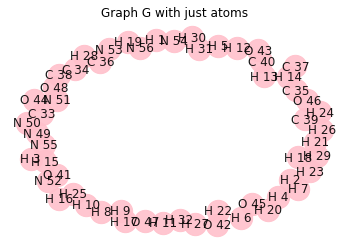

In [5]:
# Creating the graph with just atoms
# MultiGraph is being used for ease of representing
# double and possible triple bonds
# Here, 
#    - lst loops through the lists (H, C, O and N)
#    - comp loops over the compounds

G = nx.MultiGraph()
for i,lst in enumerate([H_list, C_list, O_list, N_list]):
    for comp in lst:
        G.add_node(comp, data=comp)
plot_fig(G, "Graph G with just atoms")

In [6]:
nx.nodes(G)

NodeView((H 1, H 2, H 3, H 4, H 5, H 6, H 7, H 8, H 9, H 10, H 11, H 12, H 13, H 14, H 15, H 16, H 17, H 18, H 19, H 20, H 21, H 22, H 23, H 24, H 25, H 26, H 27, H 28, H 29, H 30, H 31, H 32, C 33, C 34, C 35, C 36, C 37, C 38, C 39, C 40, O 41, O 42, O 43, O 44, O 45, O 46, O 47, O 48, N 49, N 50, N 51, N 52, N 53, N 54, N 55, N 56))

In [7]:
# Function to update the valencies of the atoms
# This function updates the atom valencies based 
# on the number of edges that atom forms.

def fix_valencies(G):
    for node in nx.nodes(G):
        degree = len(G[node])
        if degree > 0:
            node.current_valency(G)

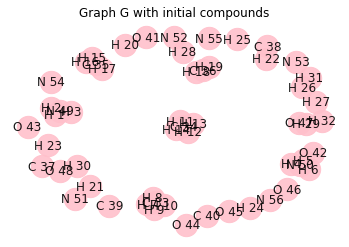

In [8]:
# Adding all the nodes

G.add_edges_from([(H_list[0], N_list[0]), (N_list[0], H_list[1]), (N_list[0], H_list[2])])
G.add_edges_from([(H_list[3], N_list[1]), (N_list[1], H_list[4]), (N_list[1], H_list[5])])

G.add_edges_from([(H_list[6], C_list[0]), (H_list[7], C_list[0]), (H_list[8], C_list[0]), (H_list[9], C_list[0])])
G.add_edges_from([(H_list[10], C_list[1]), (H_list[11], C_list[1]), (H_list[12], C_list[1]), (H_list[13], C_list[1])])

#Added CH3, CH2 and OH to test bond formations. Can be erased later.
G.add_edges_from([(H_list[14], C_list[2]), (H_list[15], C_list[2]), (H_list[16], C_list[2])])
G.add_edges_from([(H_list[17], C_list[3]), (H_list[18], C_list[3])])
G.add_edge(O_list[6], H_list[28])

fix_valencies(G)
plot_fig(G, "Graph G with initial compounds")

first_G = G.copy()
fix_valencies(first_G)

In [9]:
nx.nodes(G)

NodeView((H 1, H 2, H 3, H 4, H 5, H 6, H 7, H 8, H 9, H 10, H 11, H 12, H 13, H 14, H 15, H 16, H 17, H 18, H 19, H 20, H 21, H 22, H 23, H 24, H 25, H 26, H 27, H 28, H 29, H 30, H 31, H 32, C 33, C 34, C 35, C 36, C 37, C 38, C 39, C 40, O 41, O 42, O 43, O 44, O 45, O 46, O 47, O 48, N 49, N 50, N 51, N 52, N 53, N 54, N 55, N 56))

In [10]:
# Function to calculate H

def calculate_H(data, T):
    [a_2, a_1, a0, a1, a2, a3, a4, a5, _] = data

    H = sc.R*T*(-a_2*T**-2 + a_1*T**-1*np.log(T) + a0 + 0.5*a1*T + (a2*T**2)/3 + 0.25*a3*T**3 + 0.2*a4*T**4 +a5*T**-1)
    return H

# Function to calculate S

def calculate_S(data, T):
    [a_2, a_1, a0, a1, a2, a3, a4, _, a6] = data

    S = sc.R*(-0.5*a_2*T**-2 - a_1*T**-1 + a0*np.log(T) + a1*T + 0.5*a2*T**2 + (a3*T**3/3) + 0.25*a4*T**4 + a6)

    return S

# Function to calculate G

def calculate_G(H, S, T):
    G = H - T*S
    return G

In [11]:
free_electrons = []
for i in complete_list:
    val = 0
    compound_contrib = {}
    if np.size(i) > 1:
        for j in i:
            compound_contrib[j] = j.get_total_valency(G)
            val += j.get_total_valency(G)
    else:
        compound_contrib[i] = i.get_total_valency(G)
        val += i.get_total_valency(G)
    free_electrons.append((val, compound_contrib))

In [12]:
maximum_edges = 0; # 52
for lst in [H_list, C_list, O_list, N_list]:
    for atom in lst:
        maximum_edges += atom.get_max_valency()
        
maximum_edges = maximum_edges//2;
print("The maximum number of edges in G graph:", maximum_edges)

The maximum number of edges in G graph: 52


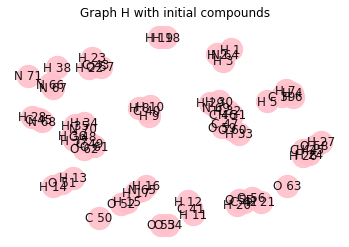

{<networkx.classes.multigraph.MultiGraph object at 0x000001EABF335F48>: -185.9402151, <networkx.classes.multigraph.MultiGraph object at 0x000001EABF391488>: -212.8851171, <networkx.classes.multigraph.MultiGraph object at 0x000001EABF60AC08>: 2.651927862, <networkx.classes.multigraph.MultiGraph object at 0x000001EABF62DD88>: 247.7699191, <networkx.classes.multigraph.MultiGraph object at 0x000001EABF494508>: -380.6041595, <networkx.classes.multigraph.MultiGraph object at 0x000001EABF497408>: -2327.0, <networkx.classes.multigraph.MultiGraph object at 0x000001EABF66FF88>: 43.5280415, <networkx.classes.multigraph.MultiGraph object at 0x000001EABF66F888>: -97.16928744, <networkx.classes.multigraph.MultiGraph object at 0x000001EABF66FE48>: -563.5848, <networkx.classes.multigraph.MultiGraph object at 0x000001EABF66FA48>: -269.5222798, <networkx.classes.multigraph.MultiGraph object at 0x000001EABF604D08>: -379.0914382, <networkx.classes.multigraph.MultiGraph object at 0x000001EABF4A2C88>: -16.7

In [13]:
H = nx.MultiGraph()

H_lists = [Compound("H",i) for i in range(1,39)]
C_lists = [Compound("C",i) for i in range(39, 51)]
O_lists = [Compound("O",i) for i in range(51, 64)]
N_lists = [Compound("N",i) for i in range(64, 72)]
for i,lst in enumerate([H_lists, C_lists, O_lists, N_lists]):
    for comp in lst:
        H.add_node(comp, data=comp)

# nx.draw(H,with_labels=True)
H.add_edges_from([(H_lists[0], N_lists[0]), (N_lists[0], H_lists[1]), (N_lists[0], H_lists[2])])
H.add_edges_from([(H_lists[3], C_lists[0]), (H_lists[4], C_lists[0]), (H_lists[5], C_lists[0]), (H_lists[6], C_lists[0])])
H.add_edges_from([(H_lists[7], C_lists[1]), (H_lists[8], C_lists[1]), (H_lists[9], C_lists[1])])
H.add_edges_from([(H_lists[10], C_lists[2]), (H_lists[11], C_lists[2])])
H.add_edges_from([(H_lists[12], O_lists[0]), (H_lists[13], O_lists[0])])
H.add_edges_from([(H_lists[14], O_lists[1])])
H.add_edges_from([(H_lists[15], N_lists[1]), (N_lists[1], H_lists[16])])
H.add_edges_from([(H_lists[17], H_lists[18])])
H.add_edges_from([(O_lists[2], O_lists[3])])
H.add_edges_from([(N_lists[2], N_lists[3])])
H.add_edges_from([(H_lists[19], C_lists[3]),(O_lists[4], C_lists[3]),(O_lists[4], C_lists[3]),(O_lists[5], C_lists[3]),(H_lists[20], O_lists[5])])
H.add_edges_from([(H_lists[21], C_lists[4]),(O_lists[6], C_lists[4]),(O_lists[6], C_lists[4]),(H_lists[22], C_lists[4])])
H.add_edges_from([(H_lists[23], C_lists[5]), (H_lists[24], C_lists[5]), (H_lists[25], C_lists[5]),(O_lists[7], C_lists[5]),(O_lists[7], H_lists[26])])
H.add_edges_from([(H_lists[27], C_lists[6]), (N_lists[4], C_lists[6]), (N_lists[4], C_lists[6]), (N_lists[4], C_lists[6])])
H.add_edges_from([(H_lists[28], N_lists[5]), (N_lists[5], H_lists[29]), (N_lists[5], C_lists[7]), (H_lists[30], C_lists[7]), (C_lists[7], H_lists[31]), (C_lists[7], C_lists[8]), (O_lists[8], C_lists[8]),(O_lists[8], C_lists[8]),(O_lists[9], C_lists[8]),(H_lists[32], O_lists[9])])
H.add_edges_from([(H_lists[33], N_lists[6]), (N_lists[6], H_lists[34]), (N_lists[6], C_lists[9]), (H_lists[35], C_lists[9]), (C_lists[9], H_lists[36]), (C_lists[9], C_lists[10]), (O_lists[10], C_lists[10]),(O_lists[10], C_lists[10]),(O_lists[11], C_lists[10])])

plot_fig(H, "Graph H with initial compounds")

data_G = {}
G_value = [-185.9402151,-212.8851171,2.651927862,247.7699191,-380.6041595,-2327.000,43.5280415,-97.16928744,-563.5848,-269.5222798,-379.0914382,-16.77210243,-664.5829247,-664.5829247,133.6241442,736.5926058,-149.516614,132.4236,-139.8716185,361.0634601]

entities = nx.connected_components(H)
entities = list(entities)
for i in range(len(entities)):
    sub = H.subgraph(list(entities[i]))
#     print(sub.nodes)
    data_G[sub] = G_value[i]
fix_valencies(H)    
print(data_G)

In [14]:
for i in G.nodes:
    i.current_valency(G)

In [15]:
# Finding G of all components given a network
def input_G(G):
    
    cc = list(nx.connected_components(G))
    G_energy = 0
    
    for i in range(len(cc)):
        found = 0
        
        # print("Connected Component G:", cc[i])
        sub_G = G.subgraph(list(cc[i]))
        same = False
        
        for j in data_G:
            # print(j.nodes)
            GH = iso.GraphMatcher(sub_G,j)
            
            # print("Isomorphic:", GH.is_isomorphic())
            if GH.is_isomorphic() == True:
                same = True
            else:
                same = False
            
            if same == True:
                if len(GH.mapping) != 2:
                    for k in GH.mapping: # check mapping of each nodes
                        # print(str(k)[0])
                        # print(str(GH.mapping[k])[0])
                        if str(k)[0] == str(GH.mapping[k])[0]: # Each node's label (without index) should coincide
                            same = True
                        else:
                            same = False
                            break
                else:
                    keys = []
                    values = []
                    for i in GH.mapping.keys():
                        keys.append(str(i).split()[0])
                    for i in GH.mapping.keys():
                        values.append(str(i).split()[0])
                    keys = keys.sort()
                    values = values.sort()
                    if keys == values:
                        same = True
                    else: 
                        same = False
                        
                # print(same)
                
            if same == True: # If compound is found, add G
                found = 1
                break

        if same == True:
            G_energy += data_G[j]
            
        elif same == False: # If compound not found,
            randomp = G.subgraph(list(cc[i]))
            plot_fig(randomp)
            
            val = float(input('Enter G value of %s: '%list(cc[i])))
            data_G[sub_G] = val # Add the new compound's data to our dictionary
            G_energy += val
            # print(G_energy)
    return G_energy

In [16]:
def get_exp_number_bonds(s, max_bonds):
    # Function imitates a Michaelis-Menten curve
    # for the number of bonds allowable at a 
    # given cycle and ceils the value returned.
    bond = math.ceil((max_bonds*s)/(0.5 + s))
    
    return bond

In [17]:
def get_neutral_compound(G):
    G_new = G.copy()
    connected_components = list(nx.connected_components(G_new))
    for i in nx.nodes(G_new): 
        i.current_valency(G_new)
    single_nodes = [list(i) for i in connected_components if len(i) == 1]
    
    for cc in connected_components:
        if len(cc) > 1:
            M = G_new.subgraph(list(cc))
            for node in nx.nodes(M):
                neigh_sum = 0
                if node._valency != 0:
                    neigh_valencies = [(i._valency, i) for i in nx.neighbors(G_new,node)]
                    for i in neigh_valencies: neigh_sum += i[0]
                        
                    if len(neigh_valencies)>0:
                        possible_neigh = [(i,x[0],x[1]) for i,x in enumerate(neigh_valencies) if x[0]>0]
                        if len(possible_neigh) > 1:
                            pos = random.randint(0, len(possible_neigh)-1)
                            for i in range(min(node._valency, possible_neigh[pos][1])):
                                G_new.add_edge(node, possible_neigh[pos][2])
                        elif len(possible_neigh)==1:
                            pos = 0
                            G_new.add_edge(node, possible_neigh[pos][2])

                    if (neigh_sum == 0):
                        noof_H = 0
                        H_nodes = []
                        for i in single_nodes:
                            if i[0]._name.split()[0] == "H":
                                H_nodes.append(i[0])
                                noof_H += 1
                                
                        if node._valency <= noof_H:
                            for i in range(node._valency):
                                G_new.add_edge(node, H_nodes[i])
                        else:
                            N = len(nx.nodes(G_new))
                            for i in range(node._valency):
                                G_new.add_node(Compound("H", i+N))
                                G_new.add_edge(node, Compound("H", i+N))
                    
                    single_nodes = [list(i) for i in nx.connected_components(G_new) if len(i)==1]

                for i in nx.nodes(G_new):
                    i.current_valency(G_new)
    return G_new

In [18]:
def generate_random_graphs(G, max_bonds, probab, max_size):
    G_new = G.copy()
    nodes = []
    for i in nx.connected_components(G_new):
        if len(i) < max_size:
            nodes.extend(list(i))
    # print("Length:", len(nodes))
    connected_components = nx.connected_components(G_new)
    # for i in connected_components:
    #    if len(i) > 1:
    #        plot_fig(G_new.subgraph(list(i)))
    
    num_executed = 0
    bonds = get_exp_number_bonds(probab, max_bonds)
    # print("Bonds to be formed:", bonds)
    # print("Number of edges:", nx.number_of_edges(G_new))
    if bonds > max_bonds:
        bonds = 0

    while (nx.number_of_edges(G_new) < bonds) and (len(nodes)>0):
        num_executed += 1
        # ipdb.set_trace()
        # print("Bonds to be formed:", bonds)
        # print("Number of edges:", nx.number_of_edges(G_new))
        flag = 0
        initial_net = G_new
        row = random.randint(0,len(nodes)-1)
        cur_val1 = (nodes[row])._valency
        # ipdb.set_trace()
        while not(cur_val1 >= 1):
            flag = 1
            row = random.randint(0,len(nodes)-1)
            cur_val1 = nodes[row]._valency
        else:
            # print("Row:", row)
            # print("Node1:", nodes[row]._name)
            # print("Curr val1:", cur_val1)
            col = random.randint(0, len(nodes)-1)
            cur_val2 = nodes[col]._valency
            while (not(cur_val2 >= 1)) or (row==col):
                flag = 2
                col = random.randint(0, len(nodes)-1)
                cur_val2 = nodes[col]._valency
                # print("Random node choosen:", nodes[col]._name)
                if cur_val2 > 0:
                    max_num_edges = random.randint(1, min(nodes[row]._valency, nodes[col]._valency))
                    # print("Col:", col)
                    # print("Node2:", nodes[col]._name)
                    # print("Curr val2:", cur_val2)
                    # print(nodes[row]._valency, nodes[col]._valency)
                    # print("max_num_edges:", max_num_edges)
                            
                    for times in range(max_num_edges):
                        G_new.add_edge(nodes[row], nodes[col])
            
            # Pruning any self edges
            for i in range(len(nodes)):
                neigh = G_new[nodes[i]]
                while nodes[i] in neigh:
                    G_new.remove_edge(nodes[i], nodes[i])
                
            # print("flag_end:", flag)
            if flag == 0 and (row!= col):
                if min(nodes[row]._valency, nodes[col]._valency) > 1:
                    max_num_edges = random.randint(1, min(nodes[row]._valency, nodes[col]._valency))
                else: max_num_edges = 1
                for times in range(max_num_edges):
                    G_new.add_edge(nodes[row], nodes[col])
        # plot_fig(G_new)
        for i in list(nx.nodes(G_new)):
            # if (i==nodes[row]) or (i==nodes[col]): 
            #     print(i._name, "Previous Valency:", i._valency)
            try:
                i.current_valency(G_new)
            except ValueError:
                print("ValueException occured !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                # print(i._name)
                # print(i._valency)
                ipdb.set_trace()
                for cc in nx.connected_components(G_new):
                    if nodes[row] in cc:
                        plot_fig(G_new.subgraph(list(cc)))
            # if (i==nodes[row]) or (i==nodes[col]): 
            #     print(i._name, "Current valency:", i._valency)
                
        nodes = []
        for i in nx.connected_components(G_new):
            if len(i) < max_size:
                nodes.extend(list(i))
        
    print("Executed:", num_executed)
    # plot_fig(G_new)
    G_new = get_neutral_compound(G_new)
    
    return G_new

In [19]:
def rearrange_connected_components(G, cc, n, times):
    for i in range(times):
        comp1_idx = random.randint(0,n-1)
        comp2_idx = random.randint(0,n-1)
        comp1 = G.subgraph(list(cc[comp1_idx]))
        comp2 = G.subgraph(list(cc[comp2_idx]))
        
        attr1 = nx.get_edge_attributes(comp1, 'number')
        attr2 = nx.get_edge_attributes(comp2, 'number')
        num_rewire = 0
        
        if len(attr1) > 0 and len(attr2) > 0:
            rewire_flag = False
            attempt = 0
            # Allowing t approx 3 attempts max, in case it didn't rewire
            while (rewire_flag == False) and (attempt < 3):
                edge1_idx = random.randint(0,len(attr1)-1)
                edge1_valence = list(attr1.values())[edge1_idx]
                edge1_nodes = list(attr1.keys())[edge1_idx]

                possible_edge2_nodes = [i for i in attr2 if attr2[i]==edge1_valence]
                if len(possible_edge2_nodes) >= 1: 
                    r = random.randint(0, len(possible_edge2_nodes)-1)
                    edge2_nodes = possible_edge2_nodes[r]
                    
                    G.remove_edge(edge1_nodes[0], edge1_nodes[1])
                    G.remove_edge(edge2_nodes[0], edge2_nodes[1])
                    num_rewire += 1
                    rewire_flag = True
                    attempt += 1
                    for number in range(edge1_valence):
                        G.add_edge(edge1_nodes[0], edge2_nodes[0])
                        G.add_edge(edge1_nodes[1], edge2_nodes[1])
        
        if len(attr1) > 0 and len(attr2) == 0:
            max_valency = list(cc[comp2_idx])[0]._valency
            possible_edge1_nodes = [i for i in attr1 if attr1[i]<=max_valency]
            if len(possible_edge1_nodes) >= 1:
                r = random.randint(0, len(possible_edge1_nodes)-1)
                edge1_nodes = possible_edge1_nodes[r]
                valency = attr1[edge1_nodes]

                G.remove_edge(edge1_nodes[0], edge1_nodes[1])
                num_rewire += 1
                for number in range(valency):
                    G.add_edge(edge1_nodes[0], list(cc[comp2_idx])[0])

        if len(attr2) > 0 and len(attr1) == 0:
            max_valency = list(cc[comp1_idx])[0]._valency
            possible_edge2_nodes = [i for i in attr2 if attr2[i]<=max_valency]
            if len(possible_edge2_nodes) >= 1: 
                r = random.randint(0, len(possible_edge2_nodes)-1)
                edge2_nodes = possible_edge2_nodes[r]
                valency = attr2[edge2_nodes]

                G.remove_edge(edge2_nodes[0], edge2_nodes[1])
                num_rewire += 1
                for number in range(valency):
                    G.add_edge(edge2_nodes[0], list(cc[comp1_idx])[0])
                    
        for i in nx.nodes(G):
            i.current_valency(G)
        
    return G

In [20]:
# Simulated Annealing

def simulated_annealing(best_G, max_bonds, least_energy, bond_factor, T, max_size):
    p = random.uniform(0.0, 1.0)
    cc = list(nx.connected_components(G))
    n = len(cc)
    
    if p < 0.1:
        times = n//2        
        G_rand = generate_random_graphs(G, max_bonds, bond_factor, max_size)
        G_new = rearrange_connected_components(G_rand, cc, n, times)
        new_energy = input_G(G_new)
        rand_energy = input_G(G_rand)
    
    elif p < 0.6:
        times = min(n//2, 2)
        G_rand = generate_random_graphs(G, max_bonds, bond_factor, max_size)
        G_new = rearrange_connected_components(G_rand, cc, n, times)
        new_energy = input_G(G_new)
        rand_energy = input_G(G_rand)
    
    else:
        times = min(n//2, 1)
        G_rand = generate_random_graphs(G, max_bonds, bond_factor, max_size)
        G_new = rearrange_connected_components(G_rand, cc, n, times)
        new_energy = input_G(G_new)
        rand_energy = input_G(G_rand)
        
    if new_energy < least_energy and new_energy < rand_energy:
        best_G = G_new
        least_energy = new_energy
    elif rand_energy < new_energy and rand_energy < least_energy:
        best_G = G_rand
        least_energy = rand_energy
    else:
        p_decide = random.uniform(0.0,1.0)
        try:
            accept_new = math.exp(-(new_energy-least_energy)/T)
        except:
            if (new_energy-least_energy) > 0:
                accept_new = 0
            else:
                accept_new = float('inf')
        try:
            accept_rand = math.exp(-(rand_energy-least_energy)/T)
        except:
            if (rand_energy-least_energy) > 0:
                accept_rand = 0
            else:
                accept_rand = float('inf')

        if p_decide < accept_new:
            best_G = G_new
            least_energy = new_energy
        elif p_decide < accept_rand:
            best_G = G_rand
            least_energy = rand_energy
    
    return (best_G, least_energy)   

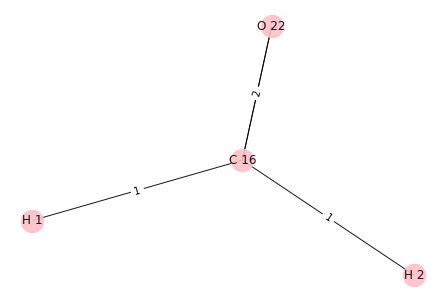

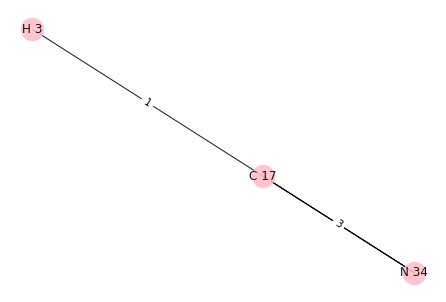

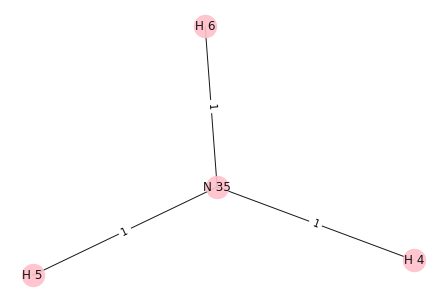

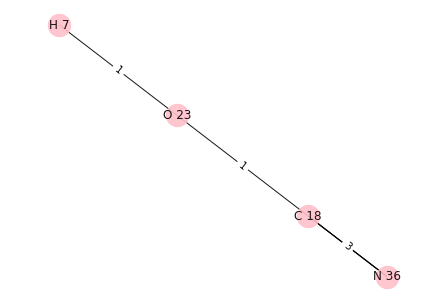

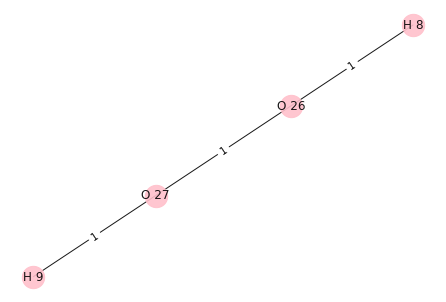

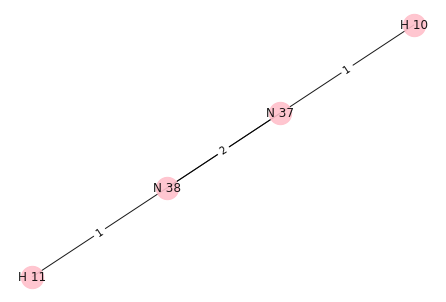

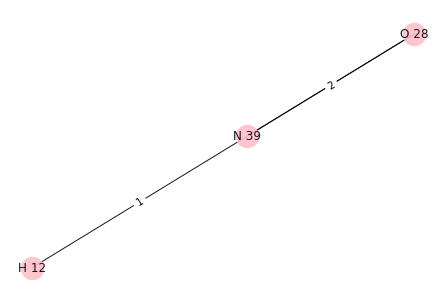

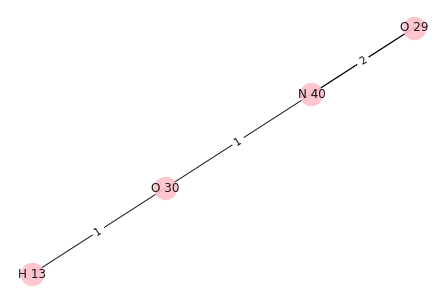

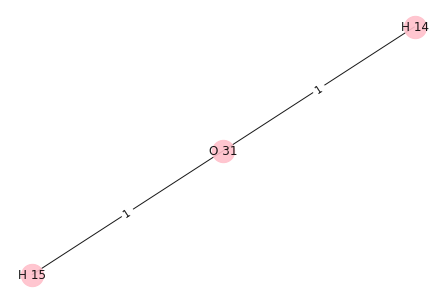

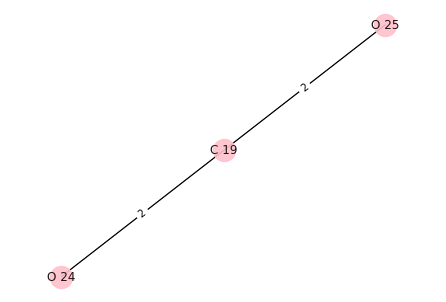

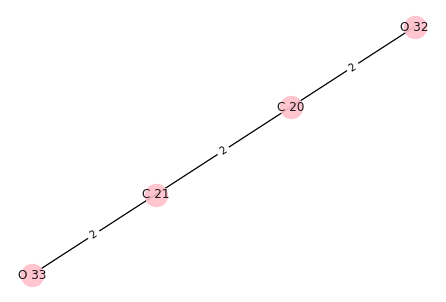

In [21]:
#Resultant compounds of size = 3/4

N = nx.MultiGraph()

H_list_n = [Compound("H",i) for i in range(1,16)]
C_list_n = [Compound("C",i) for i in range(16, 22)]
O_list_n = [Compound("O",i) for i in range(22, 34)]
N_list_n = [Compound("N",i) for i in range(34, 41)]
for i,lst in enumerate([H_list_n, C_list_n, O_list_n, N_list_n]):
    for comp in lst:
        N.add_node(comp, data=comp)
#CH2O        
N.add_edges_from([(H_list_n[0], C_list_n[0]), (H_list_n[1], C_list_n[0]), (O_list_n[0], C_list_n[0]), (O_list_n[0], C_list_n[0])])
#HCN
N.add_edges_from([(C_list_n[1], H_list_n[2]), (C_list_n[1], N_list_n[0]), (C_list_n[1], N_list_n[0]), (C_list_n[1], N_list_n[0])])
#NH3
N.add_edges_from([(H_list_n[3], N_list_n[1]), (N_list_n[1], H_list_n[4]), (N_list_n[1], H_list_n[5])])
#CNOH
N.add_edges_from([(C_list_n[2], N_list_n[2]), (C_list_n[2], N_list_n[2]), (C_list_n[2], N_list_n[2]), (C_list_n[2], O_list_n[1]), (O_list_n[1], H_list_n[6])])
#CO2
N.add_edges_from([(O_list_n[2], C_list_n[3]), (O_list_n[2], C_list_n[3]), (O_list_n[3], C_list_n[3]), (O_list_n[3], C_list_n[3])])
#H2O2
N.add_edges_from([(O_list_n[4], H_list_n[7]), (O_list_n[4], O_list_n[5]), (O_list_n[5], H_list_n[8])])
#N2H2
N.add_edges_from([(H_list_n[9], N_list_n[3]), (N_list_n[3], N_list_n[4]), (N_list_n[3], N_list_n[4]), (H_list_n[10], N_list_n[4])])
#HNO
N.add_edges_from([(H_list_n[11], N_list_n[5]), (O_list_n[6], N_list_n[5]), (O_list_n[6], N_list_n[5])])
#HNO2
N.add_edges_from([(O_list_n[7], N_list_n[6]), (O_list_n[7], N_list_n[6]), (O_list_n[8], N_list_n[6]), (O_list_n[8], H_list_n[12])])
#H2O
N.add_edges_from([(H_list_n[13], O_list_n[9]), (H_list_n[14], O_list_n[9])])
#C2O2
N.add_edges_from([(O_list_n[10], C_list_n[4]), (O_list_n[10], C_list_n[4]), (C_list_n[4], C_list_n[5]), (C_list_n[5], C_list_n[4]), (O_list_n[11], C_list_n[5]), (O_list_n[11], C_list_n[5])])

fix_valencies(N)
for i in nx.connected_components(N):
    plot_fig(N.subgraph(list(i)))

Executed: 0
Executed: 0
Executed: 0
Executed: 0
Executed: 0
Executed: 0
Executed: 0
Executed: 0
Executed: 0
Executed: 0


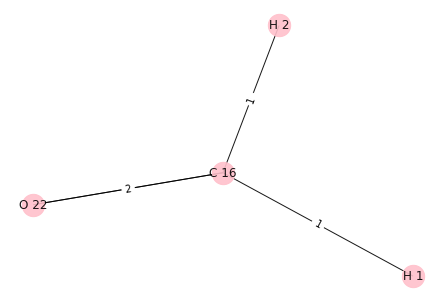

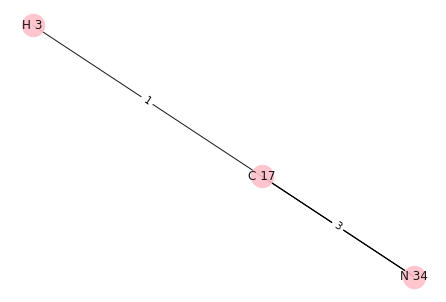

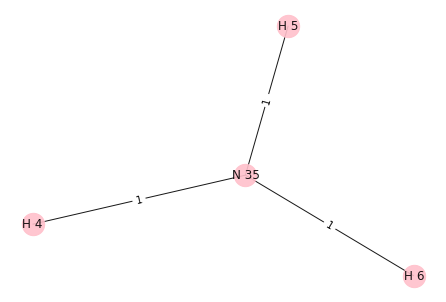

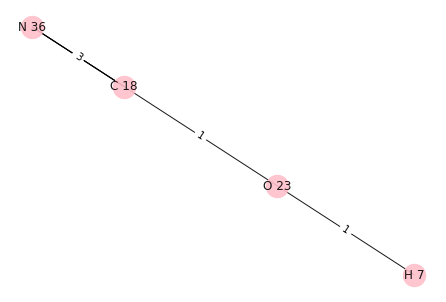

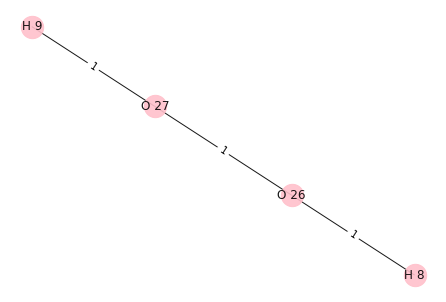

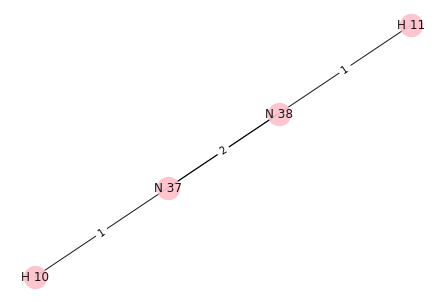

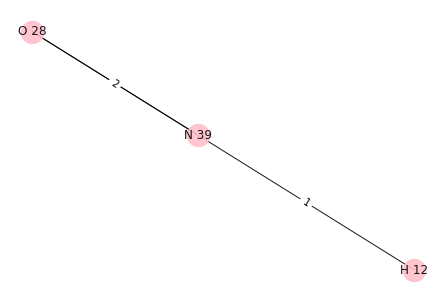

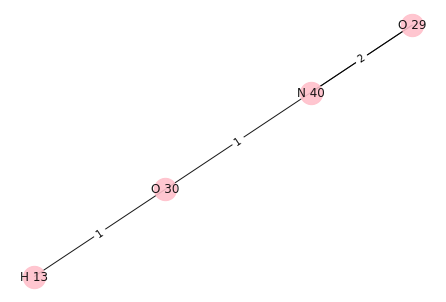

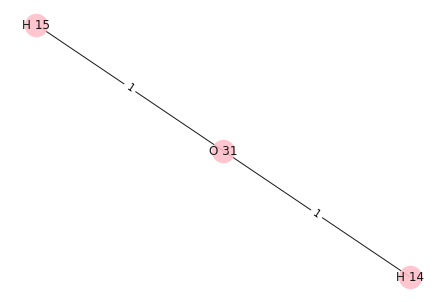

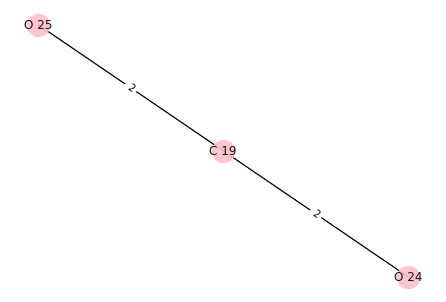

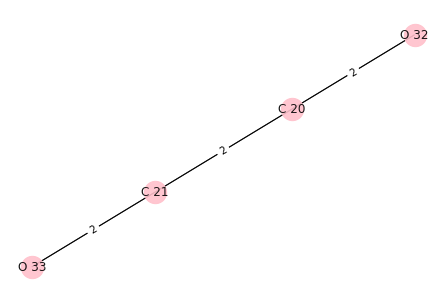

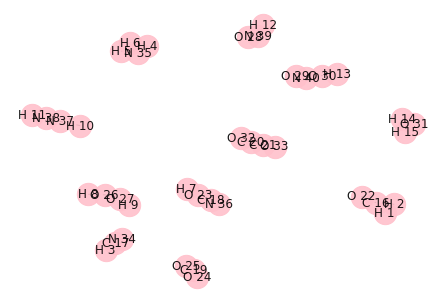

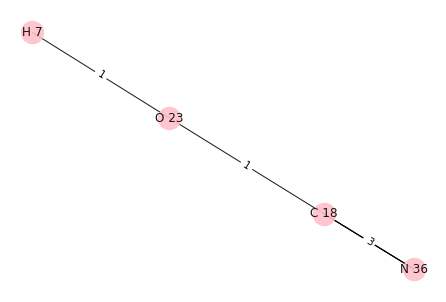

Enter G value of [H 7, N 36, O 23, C 18]: -192.79872


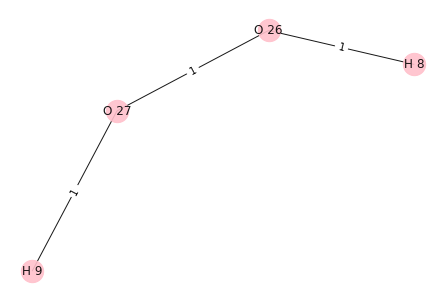

Enter G value of [H 8, O 26, H 9, O 27]: -309.1934413


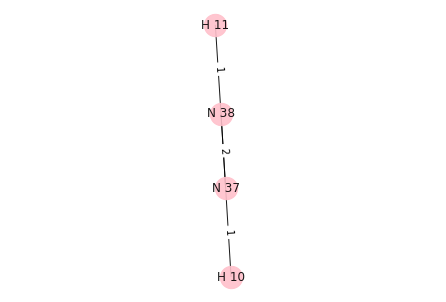

Enter G value of [H 10, N 37, N 38, H 11]: 39.66146045


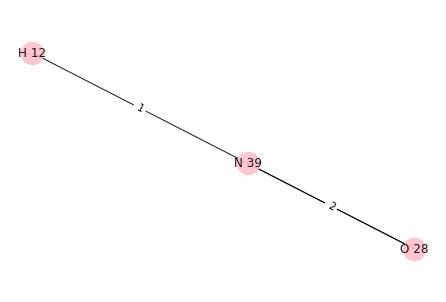

Enter G value of [N 39, O 28, H 12]: -55.64


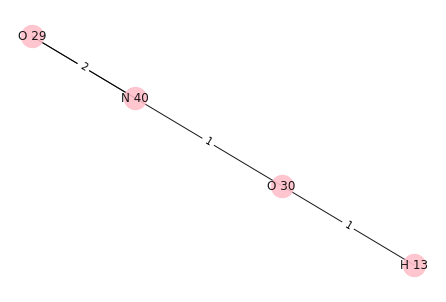

Enter G value of [O 30, N 40, O 29, H 13]: -266.6638947


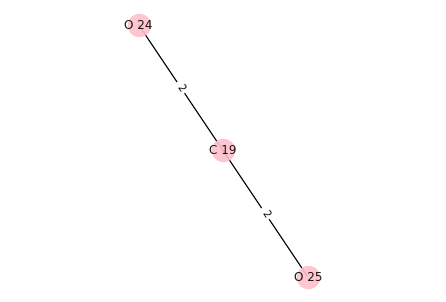

Enter G value of [C 19, O 24, O 25]: -551.2701753


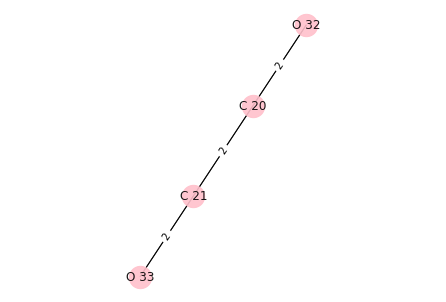

Enter G value of [C 20, C 21, O 33, O 32]: -200.95752
Executed: 0
Executed: 17


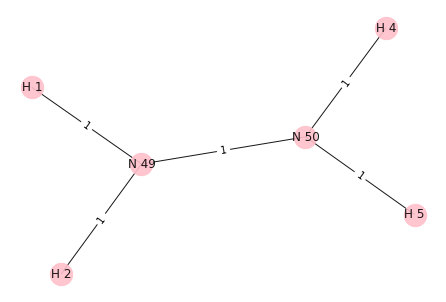

Enter G value of [H 2, N 50, N 49, H 4, H 5, H 1]: -83.16648238


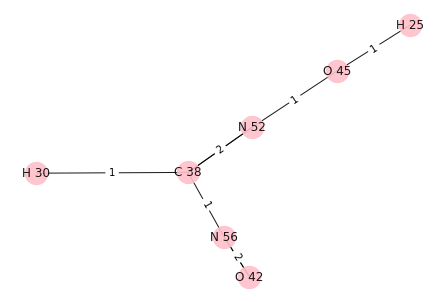

Enter G value of [O 42, H 30, N 52, C 38, O 45, N 56, H 25]: -67.99


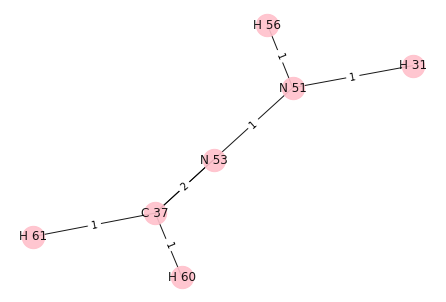

Enter G value of [N 51, H 61, C 37, H 31, H 60, H 56, N 53]: -124.59952
Executed: 27


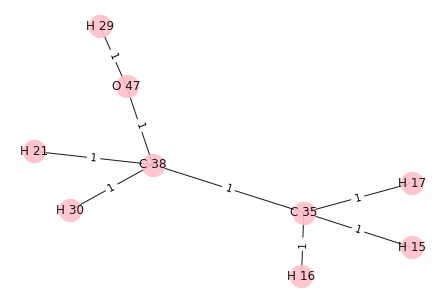

Enter G value of [H 17, C 35, H 21, H 30, O 47, C 38, H 29, H 16, H 15]: -447.4738499


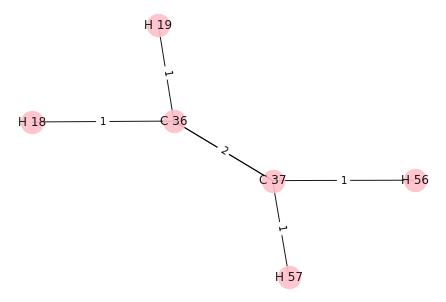

Enter G value of [H 18, C 37, H 56, H 19, C 36, H 57]: -110.876


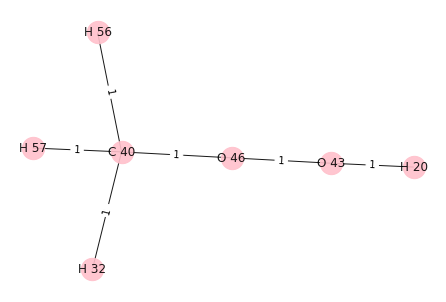

Enter G value of [H 57, H 20, C 40, H 56, H 32, O 46, O 43]: -338.3586447


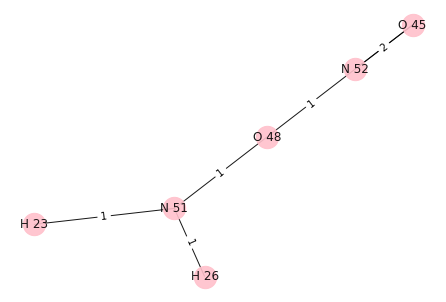

Enter G value of [N 51, H 23, N 52, O 48, O 45, H 26]: -127.31912
Executed: 25


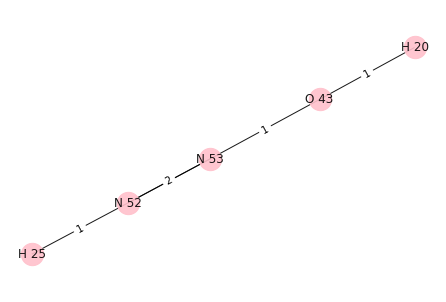

Enter G value of [N 53, H 20, N 52, H 25, O 43]: -107.61248


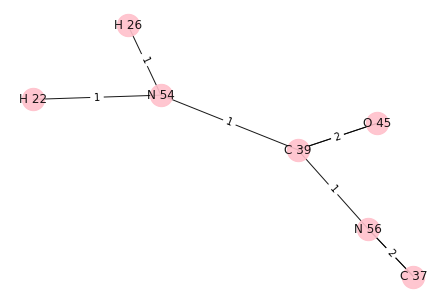

Enter G value of [H 26, N 54, C 37, O 45, N 56, H 22, C 39]: -10


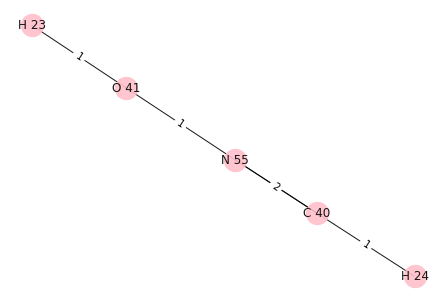

Enter G value of [H 23, C 40, H 24, N 55, O 41]: -12


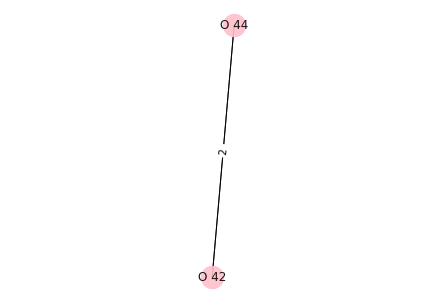

Enter G value of [O 42, O 44]: -149.516614
Executed: 27


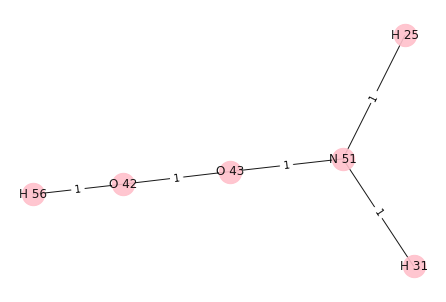

Enter G value of [N 51, O 42, H 31, H 56, H 25, O 43]: -10.85325048


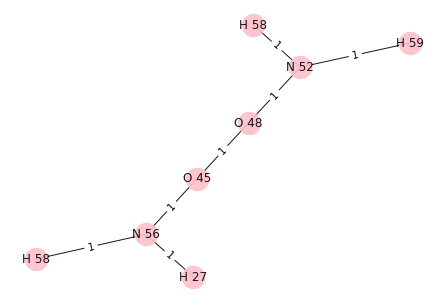

Enter G value of [H 59, H 58, N 52, O 45, O 48, N 56, H 58, H 27]: -91.50408


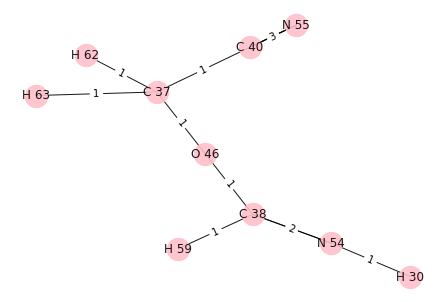

Enter G value of [H 59, H 30, N 54, C 37, C 40, H 62, C 38, N 55, H 63, O 46]: -91


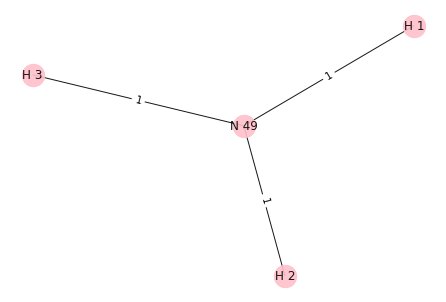

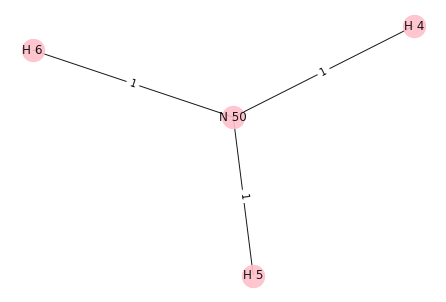

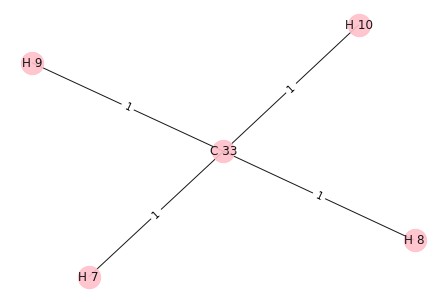

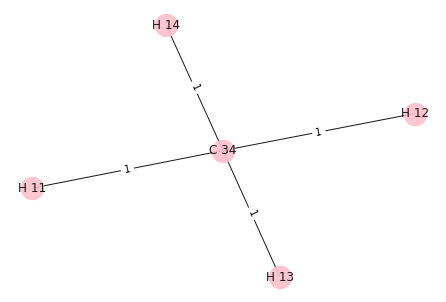

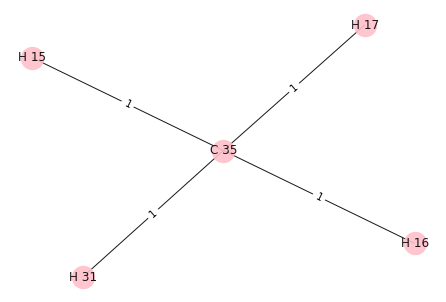

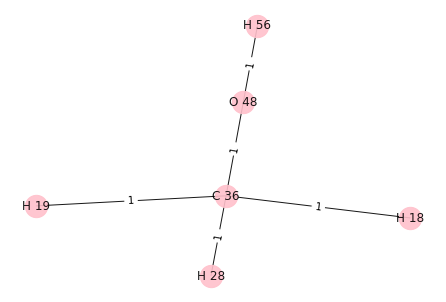

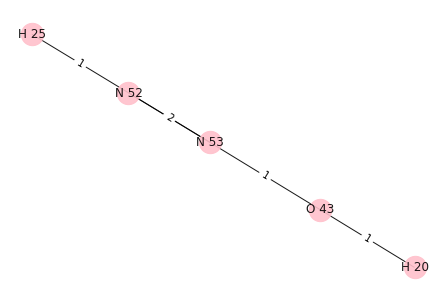

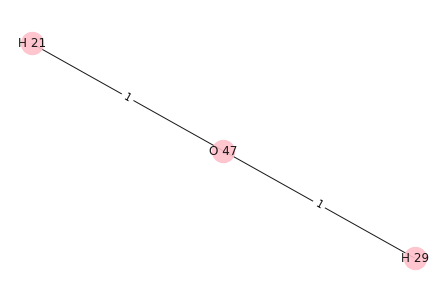

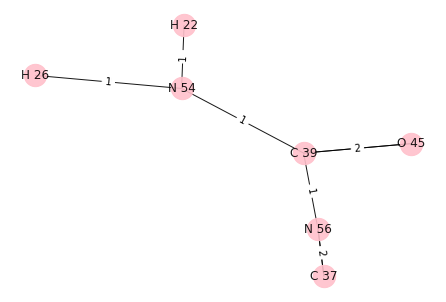

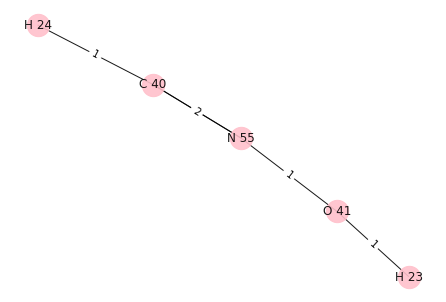

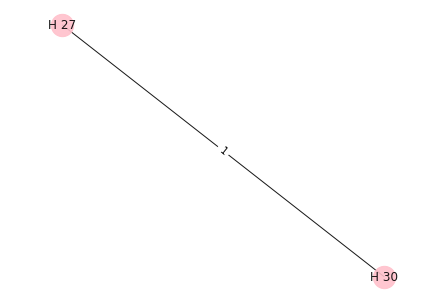

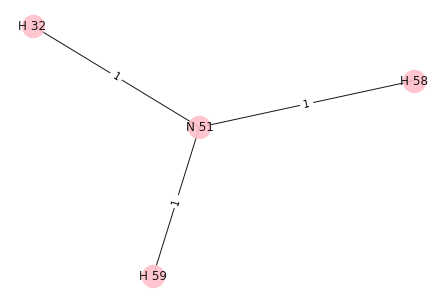

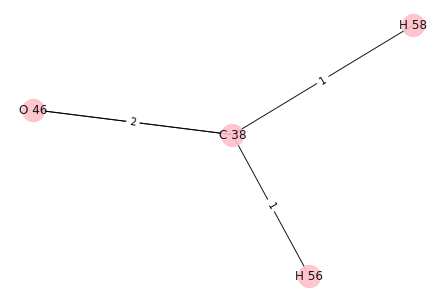

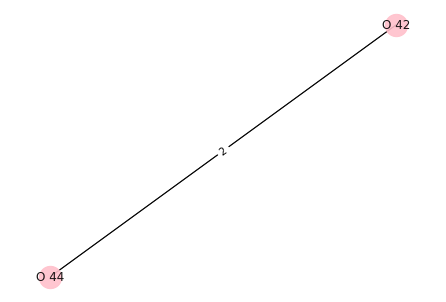

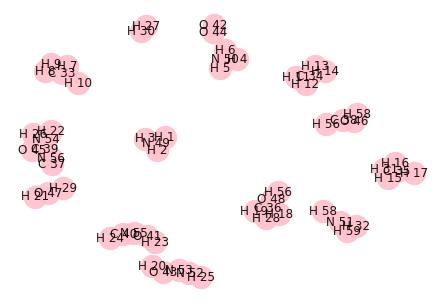

In [30]:
# #Target GLYCINE on precursors-

# trails = 10
# G_list = []
# for i in range(trails):
#     N = generate_random_graphs(N, maximum_edges, i,3)
# #     plot_fig(G_list[-1])

# new_N = nx.MultiGraph()

# for i in nx.connected_components(N):
#     if len(i)>1:
#         plot_fig(N.subgraph(list(i)))
#         new_N = nx.compose(new_N,N.subgraph(list(i)))
        
# plot_fig(new_N)
# for i in new_N.nodes:
#     i.current_valency(new_N)
    
# cycles = 5
# T = 1000
# max_size = 5
# for i in range(cycles):
#     energy = input_G(new_N)
#     new_N, energy = simulated_annealing(new_N, maximum_edges, energy, i, T, max_size)
#     T = T*0.995
# #     plot_fig(new_G)
    
# new_N6 = nx.MultiGraph()   
# for i in nx.connected_components(new_N):
#     if len(i)>1:
#         plot_fig(new_N.subgraph(list(i)))
#         new_N6 = nx.compose(new_N6,new_N.subgraph(list(i)))
        
# plot_fig(new_N6)
# for i in new_N6.nodes:
#     i.current_valency(new_N6)


Cycle:  10


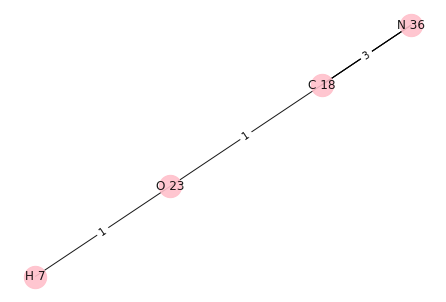

Enter G value of [H 7, O 23, N 36, C 18]: -193.3606757


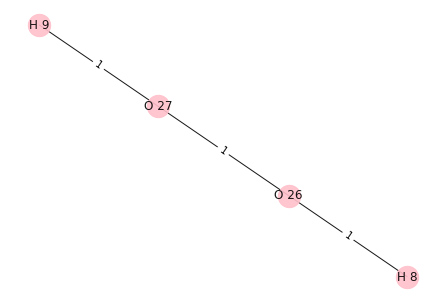

Enter G value of [H 9, O 26, H 8, O 27]: -309.1934413


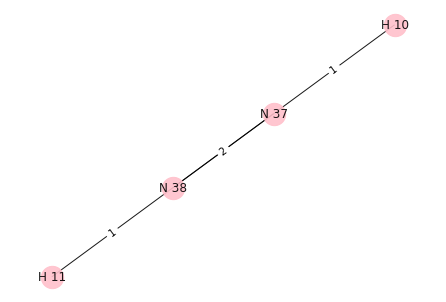

Enter G value of [H 10, N 38, N 37, H 11]: 39.66146045


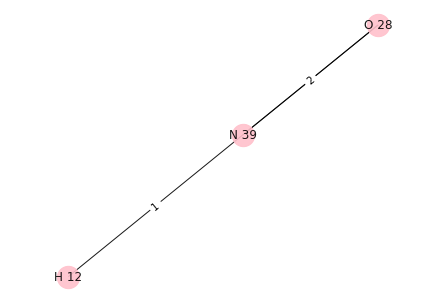

Enter G value of [N 39, O 28, H 12]: -55.64


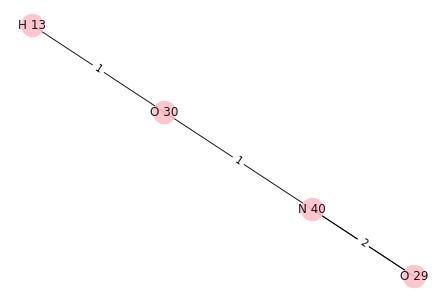

Enter G value of [O 30, O 29, H 13, N 40]: -266.6638947


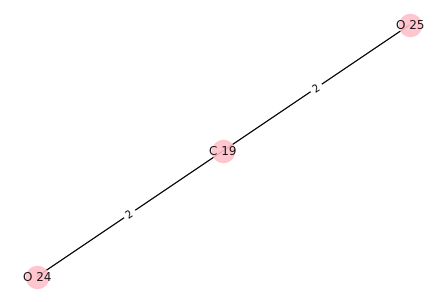

Enter G value of [C 19, O 25, O 24]: -551.2701753


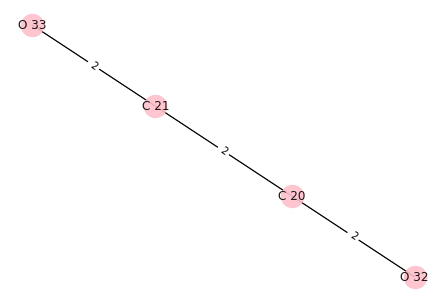

Enter G value of [O 32, C 20, O 33, C 21]: -200.95752
Executed: 0
Cycle:  10
Executed: 16


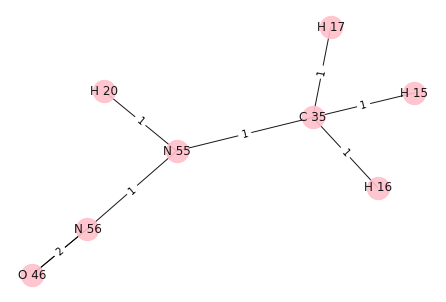

Enter G value of [O 46, H 17, N 55, H 15, H 16, C 35, N 56, H 20]: -295.68328


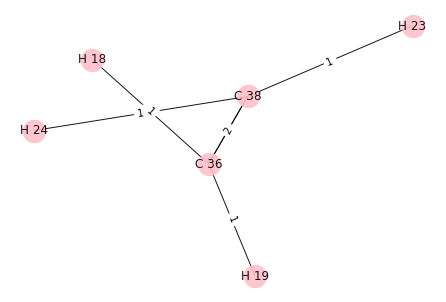

Enter G value of [C 38, C 36, H 23, H 19, H 24, H 18]: -110.876


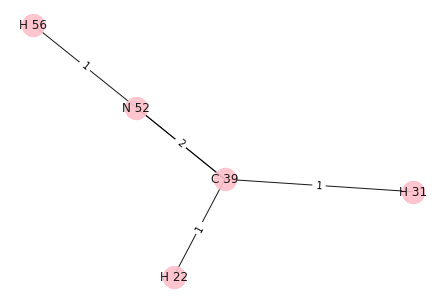

Enter G value of [C 39, N 52, H 31, H 22, H 56]: -81.53256051


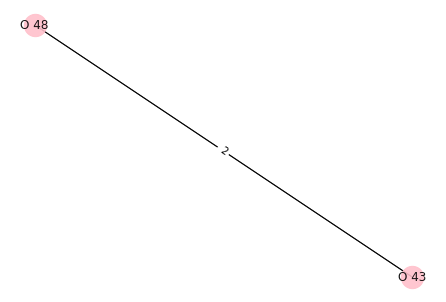

Enter G value of [O 48, O 43]: -149.516614
Cycle:  10
Executed: 22


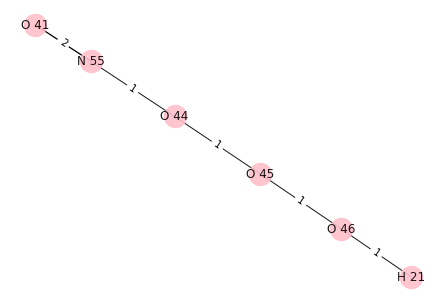

Enter G value of [O 46, O 44, N 55, O 41, O 45, H 21]: 71


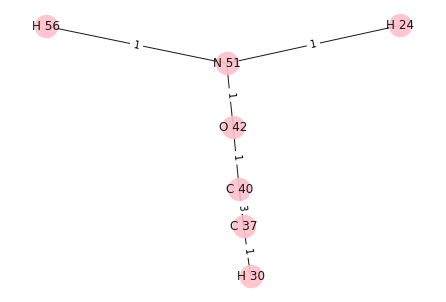

Enter G value of [N 51, H 56, O 42, H 30, C 40, C 37, H 24]: 105.2276


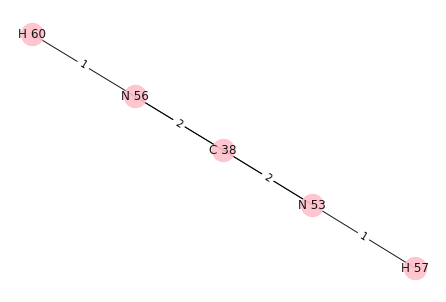

Enter G value of [H 60, N 53, N 56, C 38, H 57]: 43
Cycle:  10
Executed: 31


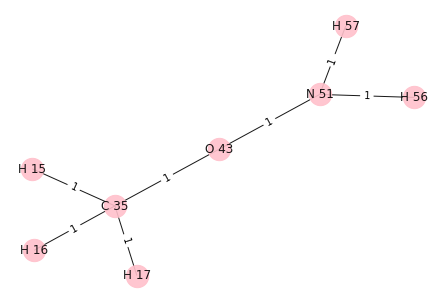

Enter G value of [N 51, H 17, H 57, H 15, H 16, C 35, H 56, O 43]: -238.11144


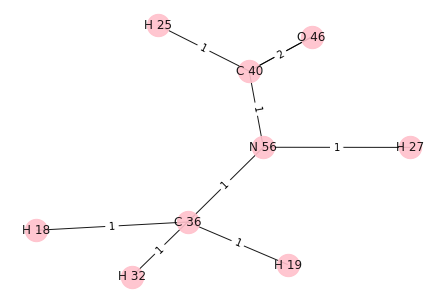

Enter G value of [C 36, O 46, H 27, H 25, H 19, C 40, N 56, H 18, H 32]: -397.81472


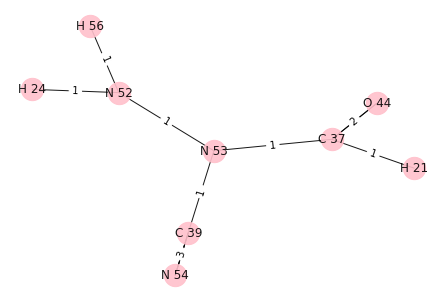

Enter G value of [C 39, N 54, O 44, C 37, N 52, H 24, H 56, N 53, H 21]: -100
Cycle:  10
Executed: 29


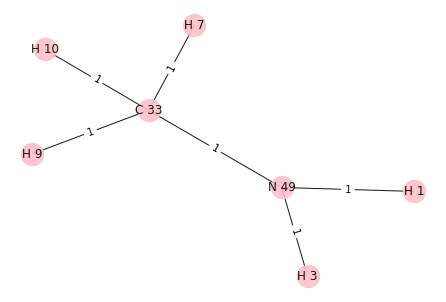

Enter G value of [H 1, C 33, H 9, H 7, H 3, N 49, H 10]: -193.3923271


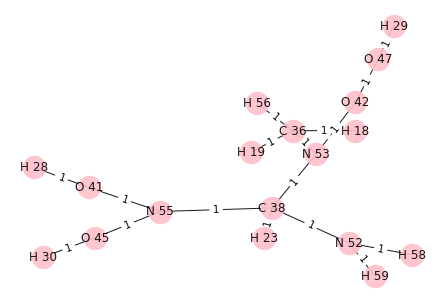

Enter G value of [C 36, C 38, N 53, O 42, H 23, H 59, O 47, H 30, H 19, N 55, N 52, O 41, H 29, H 58, H 28, H 56, O 45, H 18]: 300


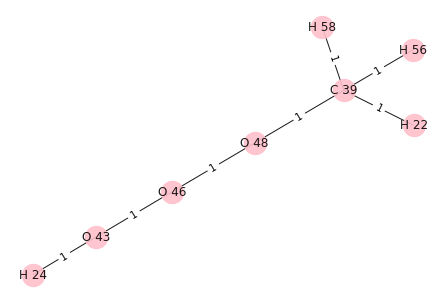

Enter G value of [O 46, C 39, H 58, O 48, H 24, O 43, H 22, H 56]: -15


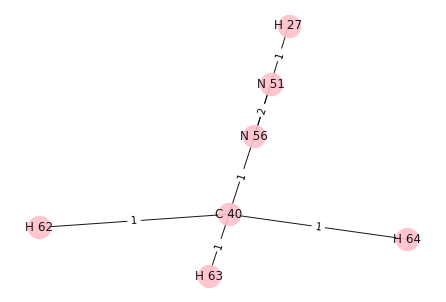

Enter G value of [N 51, H 27, H 64, C 40, N 56, H 63, H 62]: -14.81136
Cycle:  10


KeyboardInterrupt: 

In [31]:
#While loop for Glycine
#To run on G graph, change G to N1 and first_G to N. You're good to go

N1 = N.copy()
found = 0
count = 0

while (found == 0 and count<6):
    
    cycles = 5
    T = 1000
    max_size = 10
    for i in range(cycles):
        print("Cycle: ", cycles)
        energy = input_G(G)
        G, energy = simulated_annealing(G, maximum_edges, energy, i, T, max_size)
        T = T*0.995
    count+=1    
    same = False    
    for i in nx.connected_components(G):
        if len(i)==10:
            sub = G.subgraph(list(i))
            plot_fig(sub)
            GH = iso.GraphMatcher(Gly,Gly)
            
            # print("Isomorphic:", GH.is_isomorphic())
            if GH.is_isomorphic() == True:
                same = True
            else:
                same = False
            
            if same == True:
                if len(GH.mapping) != 2:
                    for k in GH.mapping: # check mapping of each nodes
                        # print(str(k)[0])
                        # print(str(GH.mapping[k])[0])
                        if str(k)[0] == str(GH.mapping[k])[0]: # Each node's label (without index) should coincide
                            same = True
                        else:
                            same = False
                            break
                else:
                    keys = []
                    values = []
                    for i in GH.mapping.keys():
                        keys.append(str(i).split()[0])
                    for i in GH.mapping.keys():
                        values.append(str(i).split()[0])
                    keys = keys.sort()
                    values = values.sort()
                    if keys == values:
                        same = True
                    else: 
                        same = False
                        
                # print(same)
                
            if same == True: # If Gly is found
                found = 1
                break
    if count==5:
        found = 1
        break
    G = first_G.copy()